# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass
from component.sup_sys.algorithm_loader import load_algorithms
from component.a_backend.fake_backend import *
from component.sup_sys.backend_loader import load_backends
from qiskit.visualization import plot_error_map

@dataclass
class ResultOfSchedule:
    numcircuit: int
    nameAlgorithm: str
    averageQubits: float
    nameSchedule: str
    typeMachine: dict
    
    # Metrics
    average_turnaroundTime: float
    average_responseTime: float
    average_fidelity: float
    sampling_overhead: float
    average_throughput: float
    average_utilization: float
    scheduler_latency: float
    makespan: float
    
result_Schedule = ResultOfSchedule(
    numcircuit=0,
    nameAlgorithm="",
    averageQubits=0.0,
    nameSchedule="",
    typeMachine={},
    
    # Metrics
    average_turnaroundTime=0.0,
    average_responseTime=0.0,
    average_fidelity=0.0,
    sampling_overhead=0.0,
    average_throughput=0.0,
    average_utilization=0.0,
    scheduler_latency=0.0,
    makespan=0.0
)

load_algorithms()
result_Schedule.nameSchedule = "FFD"


backendlist = load_backends()
print(len(backendlist))
print(backendlist)

machines = {}
backend0 = FakeBelemV2()
backend1 = FakeManilaV2()

machines[backend0.name] = backend0
machines[backend1.name] = backend0
print(machines)
# plot_error_map(list(machines.values())[0], figsize=(10, 8))

58
{'FakeAlgiers': 27, 'FakeAlmadenV2': 20, 'FakeArmonkV2': 1, 'FakeAthensV2': 5, 'FakeAuckland': 27, 'FakeBelemV2': 5, 'FakeBoeblingenV2': 20, 'FakeBogotaV2': 5, 'FakeBrisbane': 127, 'FakeBrooklynV2': 65, 'FakeBurlingtonV2': 5, 'FakeCairoV2': 27, 'FakeCambridgeV2': 28, 'FakeCasablancaV2': 7, 'FakeCusco': 127, 'FakeEssexV2': 5, 'FakeFractionalBackend': 5, 'FakeGeneva': 27, 'FakeGuadalupeV2': 16, 'FakeHanoiV2': 27, 'FakeJakartaV2': 7, 'FakeJohannesburgV2': 20, 'FakeKawasaki': 127, 'FakeKolkataV2': 27, 'FakeKyiv': 127, 'FakeKyoto': 127, 'FakeLagosV2': 7, 'FakeLimaV2': 5, 'FakeLondonV2': 5, 'FakeManhattanV2': 65, 'FakeManilaV2': 5, 'FakeMarrakesh': 156, 'FakeMelbourneV2': 15, 'FakeMontrealV2': 27, 'FakeMumbaiV2': 27, 'FakeNairobiV2': 7, 'FakeOsaka': 127, 'FakeOslo': 7, 'FakeOurenseV2': 5, 'FakeParisV2': 27, 'FakePeekskill': 27, 'FakePerth': 7, 'FakePoughkeepsieV2': 20, 'FakePrague': 33, 'FakeQuebec': 127, 'FakeQuitoV2': 5, 'FakeRochesterV2': 53, 'FakeRomeV2': 5, 'FakeSantiagoV2': 5, 'Fake

# Generate benchmark data

In [2]:
from component.b_benchmark.mqt_tool import benchmark_circuit, create_circuit
from component.sup_sys.job_info import JobInfo

# initialize the number of qubits and jobs
num_qubits_per_job = 6
num_jobs = 2
jobs = {}   

for i in range(num_jobs):
    job_id = str(i + 1)
    jobs[job_id] = num_qubits_per_job

# update to result_Schedule
result_Schedule.numcircuit = len(jobs)
result_Schedule.averageQubits = sum(jobs.values()) / len(jobs)

# generate circuits and job information
origin_job_info = {}

for job_name, num_qubits in jobs.items():
    circuit = create_circuit(num_qubits, job_name)
    result_Schedule.nameAlgorithm = "ghz"
    circuit.remove_final_measurements()
    origin_job_info[job_name] = JobInfo(
        job_name=job_name,
        qubits=circuit.num_qubits,
        machine=None,  # Placeholder for machine name
        capacity_machine=0,  # Placeholder for machine capacity
        start_time=0.0,  # Placeholder for start time
        duration=0.0,  # Placeholder for duration
        end_time=0.0,  # Placeholder for end time
        childrenJobs=None,  # Placeholder for child jobs
        circuit=circuit,
        result_cut=None,  # Placeholder for result cut
    )

# for job in origin_job_info.values():
#     job.print()
    
process_job_info = origin_job_info.copy()

# Cutting circuits

In [3]:
# Cutting the jobs into two parts with condition in process_job_info
from component.c_circuit_work.cutting.width_c import *

max_width = max(list(machines.values()), key=lambda x: x.num_qubits).num_qubits

for job_name, job_info in process_job_info.items():
    if job_info.qubits > max_width:
        job_info.childrenJobs = []
        cut_name, observable = greedy_cut(job_info.circuit, max_width)
        # print(observable)
        result_cut = gate_to_reduce_width(job_info.circuit, cut_name, observable)
        result_Schedule.sampling_overhead += result_cut.overhead
        for i, (subcircuit_name, subcircuit) in enumerate(result_cut.subcircuits.items()):
            job_info.childrenJobs.append(
                JobInfo(
                    job_name=f"{job_name}_{i+1}",
                    qubits=subcircuit.num_qubits,
                    machine=None,
                    capacity_machine=0,
                    start_time=0.0,
                    duration=0.0,
                    end_time=0.0,
                    childrenJobs=None,
                    circuit=subcircuit,
                    result_cut=None,
                )
            )
        job_info.result_cut = result_cut

# 4. Run subexperiments on a quantum backend
# for job_name, job_info in process_job_info.items():
#     if job_info.result_cut is not None:
#         result_cut = job_info.result_cut
#         backend = list(machines.values())[0] # Example backend
#         results = run_subexperiments(result_cut.subexperiments, backend)
#         reconstructed_expval, exact_expval, error_estimation, relative_error_estimation = compute_expectation_value(results, result_cut.coefficients, result_cut.subobservables, result_cut.observable, job_info.circuit)
#         print_results(reconstructed_expval, exact_expval, error_estimation, relative_error_estimation)
        
# Get the job for run scheduler

scheduler_job = {}
def get_scheduler_jobs(job_info):
    if job_info.childrenJobs is None:
        return {job_info.job_name: job_info}
    scheduler_jobs = {}
    for child_job in job_info.childrenJobs:
        scheduler_jobs.update(get_scheduler_jobs(child_job))
    return scheduler_jobs

for job_name, job_info in process_job_info.items():
    scheduler_job.update(get_scheduler_jobs(job_info))
    
print("Scheduler Jobs:")
for job_name, job_info in scheduler_job.items():
    job_info.print()

Scheduler Jobs:
Job ID: 8c69b331-7468-4d32-add9-e297bf6de032
Job Name: 1_1
Circuit:                                ┌───┐
q1_0: ─────────────────────────┤ X ├
                          ┌───┐└─┬─┘
q1_1: ────────────────────┤ X ├──■──
                     ┌───┐└─┬─┘     
q1_2: ───────────────┤ X ├──■───────
                ┌───┐└─┬─┘          
q1_3: ──────────┤ X ├──■────────────
       cut_cx_0 └─┬─┘               
q1_4: ────░───────■─────────────────
          ░                         
Qubits: 5
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Knitted Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 8c69b331-7468-4d32-add9-e297bf6de032
Job Name: 1_2
Circuit:     ┌───┐ cut_cx_0 
q2: ┤ H ├────░─────
    └───┘    ░     
Qubits: 1
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Knitted Ci

# Scheduling

Schedule saved to component/d_scheduling/scheduleResult/heuristic/FFD/schedule.json
Jobs have Updated Information:


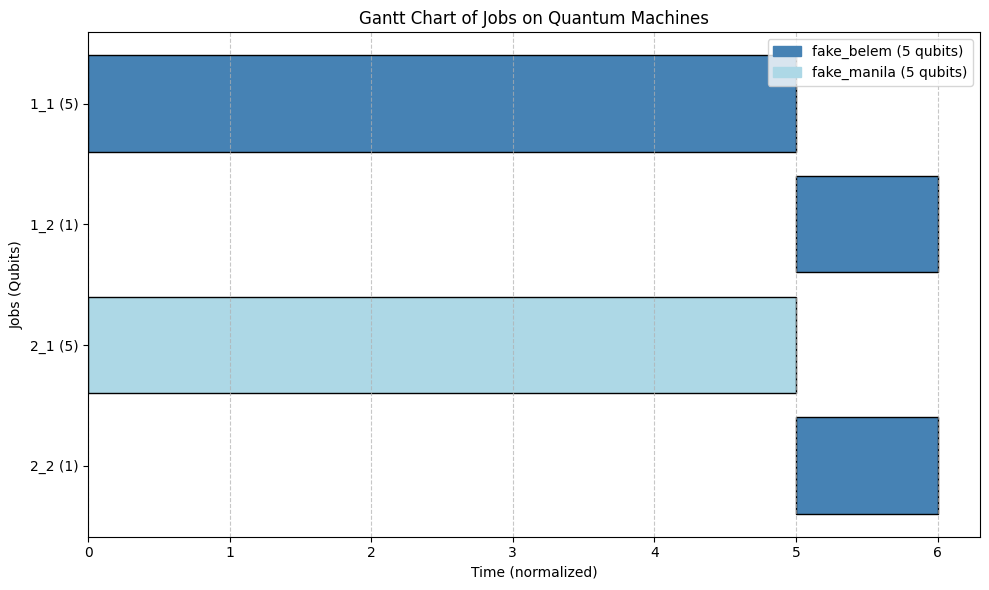

In [4]:
from component.d_scheduling.algorithm.heuristic.FFD import FFD_implement

import time
job_capacities_FFD = dict()
job_capacities_FFD = {job_name: job_info.qubits for job_name, job_info in scheduler_job.items()}
machine_capacities_FFD = {machine_name: machines[machine_name].num_qubits for machine_name in machines}
result_Schedule.typeMachine = machine_capacities_FFD
outputFFD = "component/d_scheduling/scheduleResult/heuristic/FFD"
start_time = time.time()
FFD_implement.example_problem(job_capacities_FFD, machine_capacities_FFD, outputFFD)
runtime = time.time() - start_time
result_Schedule.scheduler_latency = runtime

# Visualize data and update to dict
from component.d_scheduling.analyze import analyze_cal
from component.d_scheduling.datawork.visualize import visualize_data
from component.d_scheduling.datawork.updateToDict import update_scheduler_jobs
data = analyze_cal.load_job_data("component/d_scheduling/scheduleResult/heuristic/FFD/schedule.json")
update_scheduler_jobs(data, scheduler_job)
visualize_data(data)

# Assemble

In [5]:
from qiskit import QuantumCircuit, transpile
# Transpile circuits for all scheduled jobs
for job_id, job in scheduler_job.items():
    backend = machines.get(job.machine)
    if backend:
        # Perform transpilation
        job.circuit.data = [hasChange for hasChange in job.circuit.data if hasChange.operation.name != "qpd_1q"]
        job.transpiled_circuit = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
        # job.circuit.measure_all()
        # job.transpiled_circuit_measured = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
    else:
        print(f"No backend found for machine {job.machine}. Skipping job {job_id}.")
        
    job.print()
    
# from qiskit.visualization.timeline import draw, IQXDebugging
# draw(scheduler_job['1'].transpiled_circuit, target=machines['fake_belem'].target)

# after have the circuit we connect to
# from qiskit.visualization import plot_circuit_layout
# plot_circuit_layout(scheduler_job['1'].transpiled_circuit, machines['fake_belem'])

Job ID: 8c69b331-7468-4d32-add9-e297bf6de032
Job Name: 1_1
Circuit:                      ┌───┐
q1_0: ───────────────┤ X ├
                ┌───┐└─┬─┘
q1_1: ──────────┤ X ├──■──
           ┌───┐└─┬─┘     
q1_2: ─────┤ X ├──■───────
      ┌───┐└─┬─┘          
q1_3: ┤ X ├──■────────────
      └─┬─┘               
q1_4: ──■─────────────────
                          
Qubits: 5
Machine: fake_belem
Capacity Machine: 5
Start Time: 0.0
Duration: 50.0
End Time: 50.0
Children Jobs: None
Result Cut: None
Transpiled Circuit:           ┌─────────────────┐                                                 »
q1_0 -> 0 ┤ Delay(9536[dt]) ├─────────────────────────────────────────────────»
          └──────┬───┬──────┘            ┌───┐                           ┌───┐»
q1_1 -> 1 ───────┤ X ├─────────■─────────┤ X ├───────────────────────────┤ X ├»
                 └─┬─┘       ┌─┴─┐       └─┬─┘        ┌─────────────────┐└─┬─┘»
q1_2 -> 2 ─────────■─────────┤ X ├─────────■──────────┤ Delay(1792[dt]) ├──┼──»
  

# Allow multithreading

Calculating duration from transpiled circuit...
22176
Calculating duration from transpiled circuit...
15200
Calculating duration from transpiled circuit...
160
Calculating duration from transpiled circuit...
160


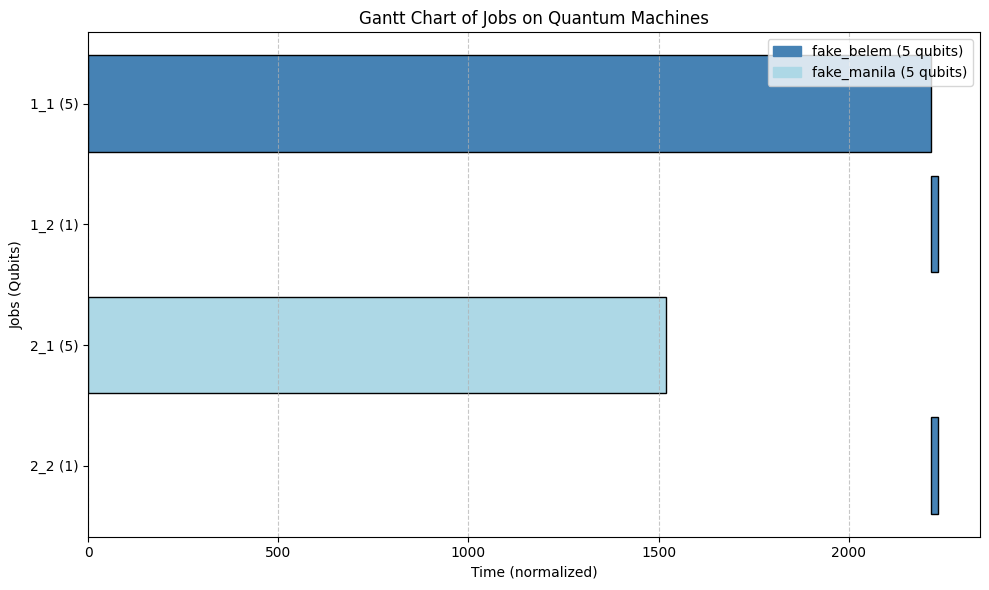

In [6]:
# ...existing code...

# For multithreading (parallel execution)
from component.d_scheduling.simulation.scheduling_multithread import simulate_scheduling as simulate_multithread

jobs = data.copy()
updated_jobs = simulate_multithread(jobs, scheduler_job)
visualize_data(updated_jobs)

# For single-threaded (no parallel execution)
# from component.d_scheduling.simulation.scheduling_singlethread import simulate_scheduling as simulate_singlethread

# jobs = data.copy()
# updated_jobs = simulate_singlethread(jobs, scheduler_job)
# for job in updated_jobs:
#     print(job)
    
# visualize_data(updated_jobs)
# ...existing code...

# Knitting

In [9]:
from qiskit import QuantumCircuit
from collections import defaultdict

from component.c_circuit_work.knitting.width_k import merge_multiple_circuits

# Example: you have circuits per job_id
job_circuits = {}
for job_id, job_info in scheduler_job.items():
    key = job_info.job_name
    
    job_circuits[key] = job_info.circuit


# Group by (machine, start_time)
grouped_jobs = defaultdict(list)
for job in updated_jobs:
    key = (job['machine'], job['start'])
    grouped_jobs[key].append(job['job'])

print("Grouped Jobs:")
for key, job_ids in grouped_jobs.items():
    print(f"{key}: {job_ids}")

# Merge circuits for each (machine, start_time)
expanded_circuits = {}
for (machine, start_time), job_ids in grouped_jobs.items():
    print(job_ids)
    circuits_to_merge = [job_circuits[job_id] for job_id in job_ids]
    print("Circuit_To_Merge")
    print(circuits_to_merge)
    if len(circuits_to_merge) == 1:
        merged_circuit = circuits_to_merge[0]  # no merge needed
    else:
        print(circuits_to_merge)
        merged_circuit = merge_multiple_circuits(circuits_to_merge)
    
    expanded_circuits[tuple(job_ids)] = merged_circuit

print("Expanded Circuits:")
print(expanded_circuits)

for keys, circuit_expand in expanded_circuits.items():
    # print(f"Expanded Circuit for {key}:")
    # print(circuit)
    circuit_expand.measure_all()
    for key in keys:
        # print(f"Job ID: {key}")
        scheduler_job[key].knitted_circuit = circuit_expand

for job_info, job_item in scheduler_job.items():
    print(job_info)
    job_item.print()
    
from qiskit import QuantumCircuit, transpile
# Transpile circuits for all scheduled jobs
for job_id, job in scheduler_job.items():
    backend = machines.get(job.machine)
    if backend:
        # Perform transpilation
        # job.transpiled_circuit = transpile(job.knitted_circuit, backend, scheduling_method='alap', layout_method='trivial')
        job.transpiled_circuit_measured = transpile(job.knitted_circuit, backend, scheduling_method='alap', layout_method='trivial')
    else:
        print(f"No backend found for machine {job.machine}. Skipping job {job_id}.")
    job.print()
    
# from qiskit.visualization.timeline import draw, IQXDebugging
# draw(scheduler_job['1'].transpiled_circuit, target=machines['fake_belem'].target)

# after have the circuit we connect to
# from qiskit.visualization import plot_circuit_layout
# plot_circuit_layout(scheduler_job['1'].transpiled_circuit, machines['fake_belem'])

Grouped Jobs:
('fake_belem', 0.0): ['1', '2']
('fake_manila', 0.0): ['3', '4']
('fake_belem', 364.8): ['5']
['1', '2']
Circuit_To_Merge
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de90756ec0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de8ae55f60>]
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de90756ec0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de8ae55f60>]
['3', '4']
Circuit_To_Merge
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71def65c7520>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de90679030>]
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71def65c7520>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de90679030>]
['5']
Circuit_To_Merge
Expanded Circuits:
{('1', '2'): <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de8ac186a0>, ('3', '4'): <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71de8ac19ba0>, ('5',): <qiskit.circuit.quantumcirc

# Simulation

In [10]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution
import qiskit.quantum_info as qi
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2
from component.f_assemble.assemble_work import fidelity_from_counts

aer_simulator = AerSimulator()
for job_name, job_info in scheduler_job.items():
    backend = machines.get(job_info.machine)
    
    if backend:
        transpiled_circuit = job_info.transpiled_circuit_measured
        # print(transpiled_circuit)
        
        # Run the ideal simulation
        ideal_result = aer_simulator.run(transpiled_circuit, shots=1024).result()
        ideal_counts = ideal_result.get_counts(transpiled_circuit)
        
        # Run circuit on the simulated backend
        job = SamplerV2(backend).run([transpiled_circuit], shots=1024)
        sim_result = job.result()[0]
        sim_counts = sim_result.data.meas.get_counts()
        # print("ideal_counts")
        # print(ideal_counts)
        # print("sim_counts")
        # print(sim_counts)
        # Calculate fidelity
        fidelity_val, rho_ideal, rho_sim = fidelity_from_counts(ideal_counts, sim_counts)
        
        # Store the fidelity values
        job_info.fidelity = fidelity_val
        
    # job_info.print()

# Calculation metrics

In [11]:
utilization_permachine = analyze_cal.calculate_utilization(data)
print(utilization_permachine)

# Check if have children jobs in origin_job_info
for job_name, job_info in origin_job_info.items():
    if job_info.childrenJobs is not None:
        count_fidelity = 0
        for child_job in job_info.childrenJobs:
            #updata start time and end time from child job to parent job
            job_info.start_time = min(job_info.start_time, child_job.start_time)
            job_info.end_time = max(job_info.end_time, child_job.end_time)
            job_info.duration = job_info.end_time - job_info.start_time
            count_fidelity += child_job.fidelity * child_job.qubits
        job_info.fidelity = count_fidelity / job_info.qubits
    else:
        print(f"Job {job_name} has no children jobs.")
        
metrics = analyze_cal.calculate_metrics(data, utilization_permachine)
analyze_cal.print_metrics(metrics)

result_Schedule.average_turnaroundTime = metrics['average_turnaroundTime']
result_Schedule.average_responseTime = metrics['average_responseTime']
result_Schedule.makespan = metrics['makespan']
result_Schedule.average_utilization = metrics['average_utilization']
result_Schedule.average_throughput = metrics['throughput']

# Calculate all the values of components
sum_fidelity = 0
for job_name, job_info in origin_job_info.items():
    sum_fidelity += job_info.fidelity * job_info.qubits
average_fidelity = sum_fidelity / (result_Schedule.averageQubits * result_Schedule.numcircuit)
result_Schedule.average_fidelity = average_fidelity

defaultdict(<class 'float'>, {'fake_belem': 0.6000000000000001, 'fake_manila': 0.8})
Job 1 has no children jobs.
Job 2 has no children jobs.
Job 3 has no children jobs.
Job 4 has no children jobs.
Job 5 has no children jobs.
729.6
5
145.92000000000002


# Save to json

In [12]:
import os
import json
from dataclasses import asdict

# Create the directory path
algorithm_folder_path = os.path.join("component", "finalResult","5_5", result_Schedule.nameSchedule, result_Schedule.nameAlgorithm)
os.makedirs(algorithm_folder_path, exist_ok=True)

# Construct the base file name
numcircuit = result_Schedule.numcircuit
numqubit = result_Schedule.averageQubits
base_filename = f"{numcircuit}_{numqubit}"

# Ensure the filename is unique
existing_files = os.listdir(algorithm_folder_path)
matching_files = [f for f in existing_files if f.startswith(base_filename) and f.endswith(".json")]

if not matching_files:
    final_filename = f"{base_filename}_0.json"
else:
    suffixes = [
        int(f.replace(base_filename, "").replace(".json", "").replace("_", ""))
        for f in matching_files
        if f.replace(base_filename, "").replace(".json", "").replace("_", "").isdigit()
    ]
    next_suffix = max(suffixes, default=0) + 1
    final_filename = f"{base_filename}_{next_suffix}.json"

# Define the output file path
output_file_path = os.path.join(algorithm_folder_path, final_filename)

# Save the result to the JSON file
with open(output_file_path, "w") as f:
    json.dump(asdict(result_Schedule), f, indent=4)

# Print the result
print(f"Result saved to {output_file_path}")

Result saved to component/finalResult/5_5/FFD/ghz/5_2.0_7.json
